# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial.

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

In [1]:
! git clone https://github.com/amn8ge/lab_tree_stability

Cloning into 'lab_tree_stability'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 798.84 KiB | 9.29 MiB/s, done.


In [2]:
!git config --global user.name "amn8ge"
!git config --global user.email "amn8ge@virginia.edu"

In [3]:
cd lab_tree_stability

/content/lab_tree_stability


In [4]:
cd data

/content/lab_tree_stability/data


In [5]:
import pandas as pd
import numpy as np

**Question** **1**

In [64]:
airbnb = pd.read_csv('airbnb_hw.csv',low_memory=False)
airbnb.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [65]:
print(airbnb.columns)
print(airbnb.shape)

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')
(30478, 13)


In [66]:
# cleaning price variable
airbnb['price_clean'] = airbnb['Price'].str.replace('$', '').str.replace(',', '')
airbnb['price_clean'] = pd.to_numeric(airbnb['price_clean'], errors='coerce')

# filtering out outliers
Q1 = airbnb['price_clean'].quantile(0.25)
Q3 = airbnb['price_clean'].quantile(0.75)
IQR = Q3 - Q1

# define lower and upper bounds for typical prices
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter out outliers
airbnb_no_outliers = airbnb[(airbnb['price_clean'] >= lower_bound) & (airbnb['price_clean'] <= upper_bound)]
airbnb.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,price_clean
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN,145
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN,37
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN,28
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN,199
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0,549


In [67]:
print(airbnb.dtypes)

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
price_clean                     int64
dtype: object


In [68]:
missing_price_count = int(airbnb['price_clean'].isna().sum())
print(missing_price_count)

# there are not missing values for price

0


In [69]:
# drop unnecessary columns
bad_cols = [
    'Host Since',
    'Name',
    'Review Scores Rating (bin)',
    'Number Of Reviews'
]
airbnb = airbnb.drop(columns=bad_cols)

# remove rows where review scores rating is missing
airbnb = airbnb.dropna(subset=['Review Scores Rating'])

# check for missing values in remaining columns
missing_sum = airbnb.isna().sum()

print("Missing values summary:")
print(missing_sum)

Missing values summary:
Host Id                   0
Neighbourhood             0
Property Type             2
Room Type                 0
Zipcode                 100
Beds                     44
Number of Records         0
Price                     0
Review Scores Rating      0
price_clean               0
dtype: int64


In [70]:
# remove entries with missing values from zipcode, beds, and property type
# check for duplicate entries

airbnb = airbnb.dropna(subset=['Zipcode', 'Beds', 'Property Type'])

# convert zipcodes to strings since they aren't numbers
airbnb['Zipcode'] = airbnb['Zipcode'].astype(int).astype(str)

airbnb.duplicated().sum()

np.int64(127)

In [71]:
# remove duplicate entries
airbnb = airbnb.drop_duplicates()
airbnb.duplicated().sum()

np.int64(0)

In [72]:
# removing white space and stripping categorical values

airbnb['Neighbourhood '] = airbnb['Neighbourhood '].str.strip().str.lower()
airbnb['Property Type'] = airbnb['Property Type'].str.strip().str.lower()
airbnb['Room Type'] = airbnb['Room Type'].str.strip().str.lower()

# renaming neighourhood column
airbnb = airbnb.rename(columns={'Neighbourhood ': 'Neighbourhood'})

In [73]:
# checking the dataset to confirm that it has been properly cleaned
airbnb.head()

,Host Id,Neighbourhood,Property Type,Room Type,Zipcode,Beds,Number of Records,Price,Review Scores Rating,price_clean
4,500,manhattan,apartment,private room,10036,3.0,1,549,96.0,549
5,1039,brooklyn,apartment,entire home/apt,11222,1.0,1,149,100.0,149
6,1783,manhattan,apartment,entire home/apt,10004,1.0,1,250,100.0,250
7,2078,brooklyn,apartment,private room,11201,1.0,1,90,94.0,90
8,2339,manhattan,apartment,entire home/apt,10009,2.0,1,270,90.0,270


In [81]:
airbnb_cleaned = airbnb.copy()

**Question 2**

Property Type: ['apartment' 'other' 'bed & breakfast' 'loft' 'condominium' 'house'
 'townhouse' 'dorm' 'boat' 'cabin' 'villa' 'bungalow' 'camper/rv'
 'treehouse' 'lighthouse' 'chalet' 'castle' 'hut']
Room Type: ['private room' 'entire home/apt' 'shared room']
Neighbourhood: ['manhattan' 'brooklyn' 'queens' 'bronx' 'staten island']
Decision Tree - MSE: 33827.04, R²: 0.125
Linear Regression - MSE: 32725.34, R²: 0.153
   actual   cart_pred  linreg_pred
0      65   65.501149    56.234861
1     100  148.558720   136.645493
2     140  203.586518   188.214523
3     140  101.617337   149.551607
4     425  284.238494   257.894115


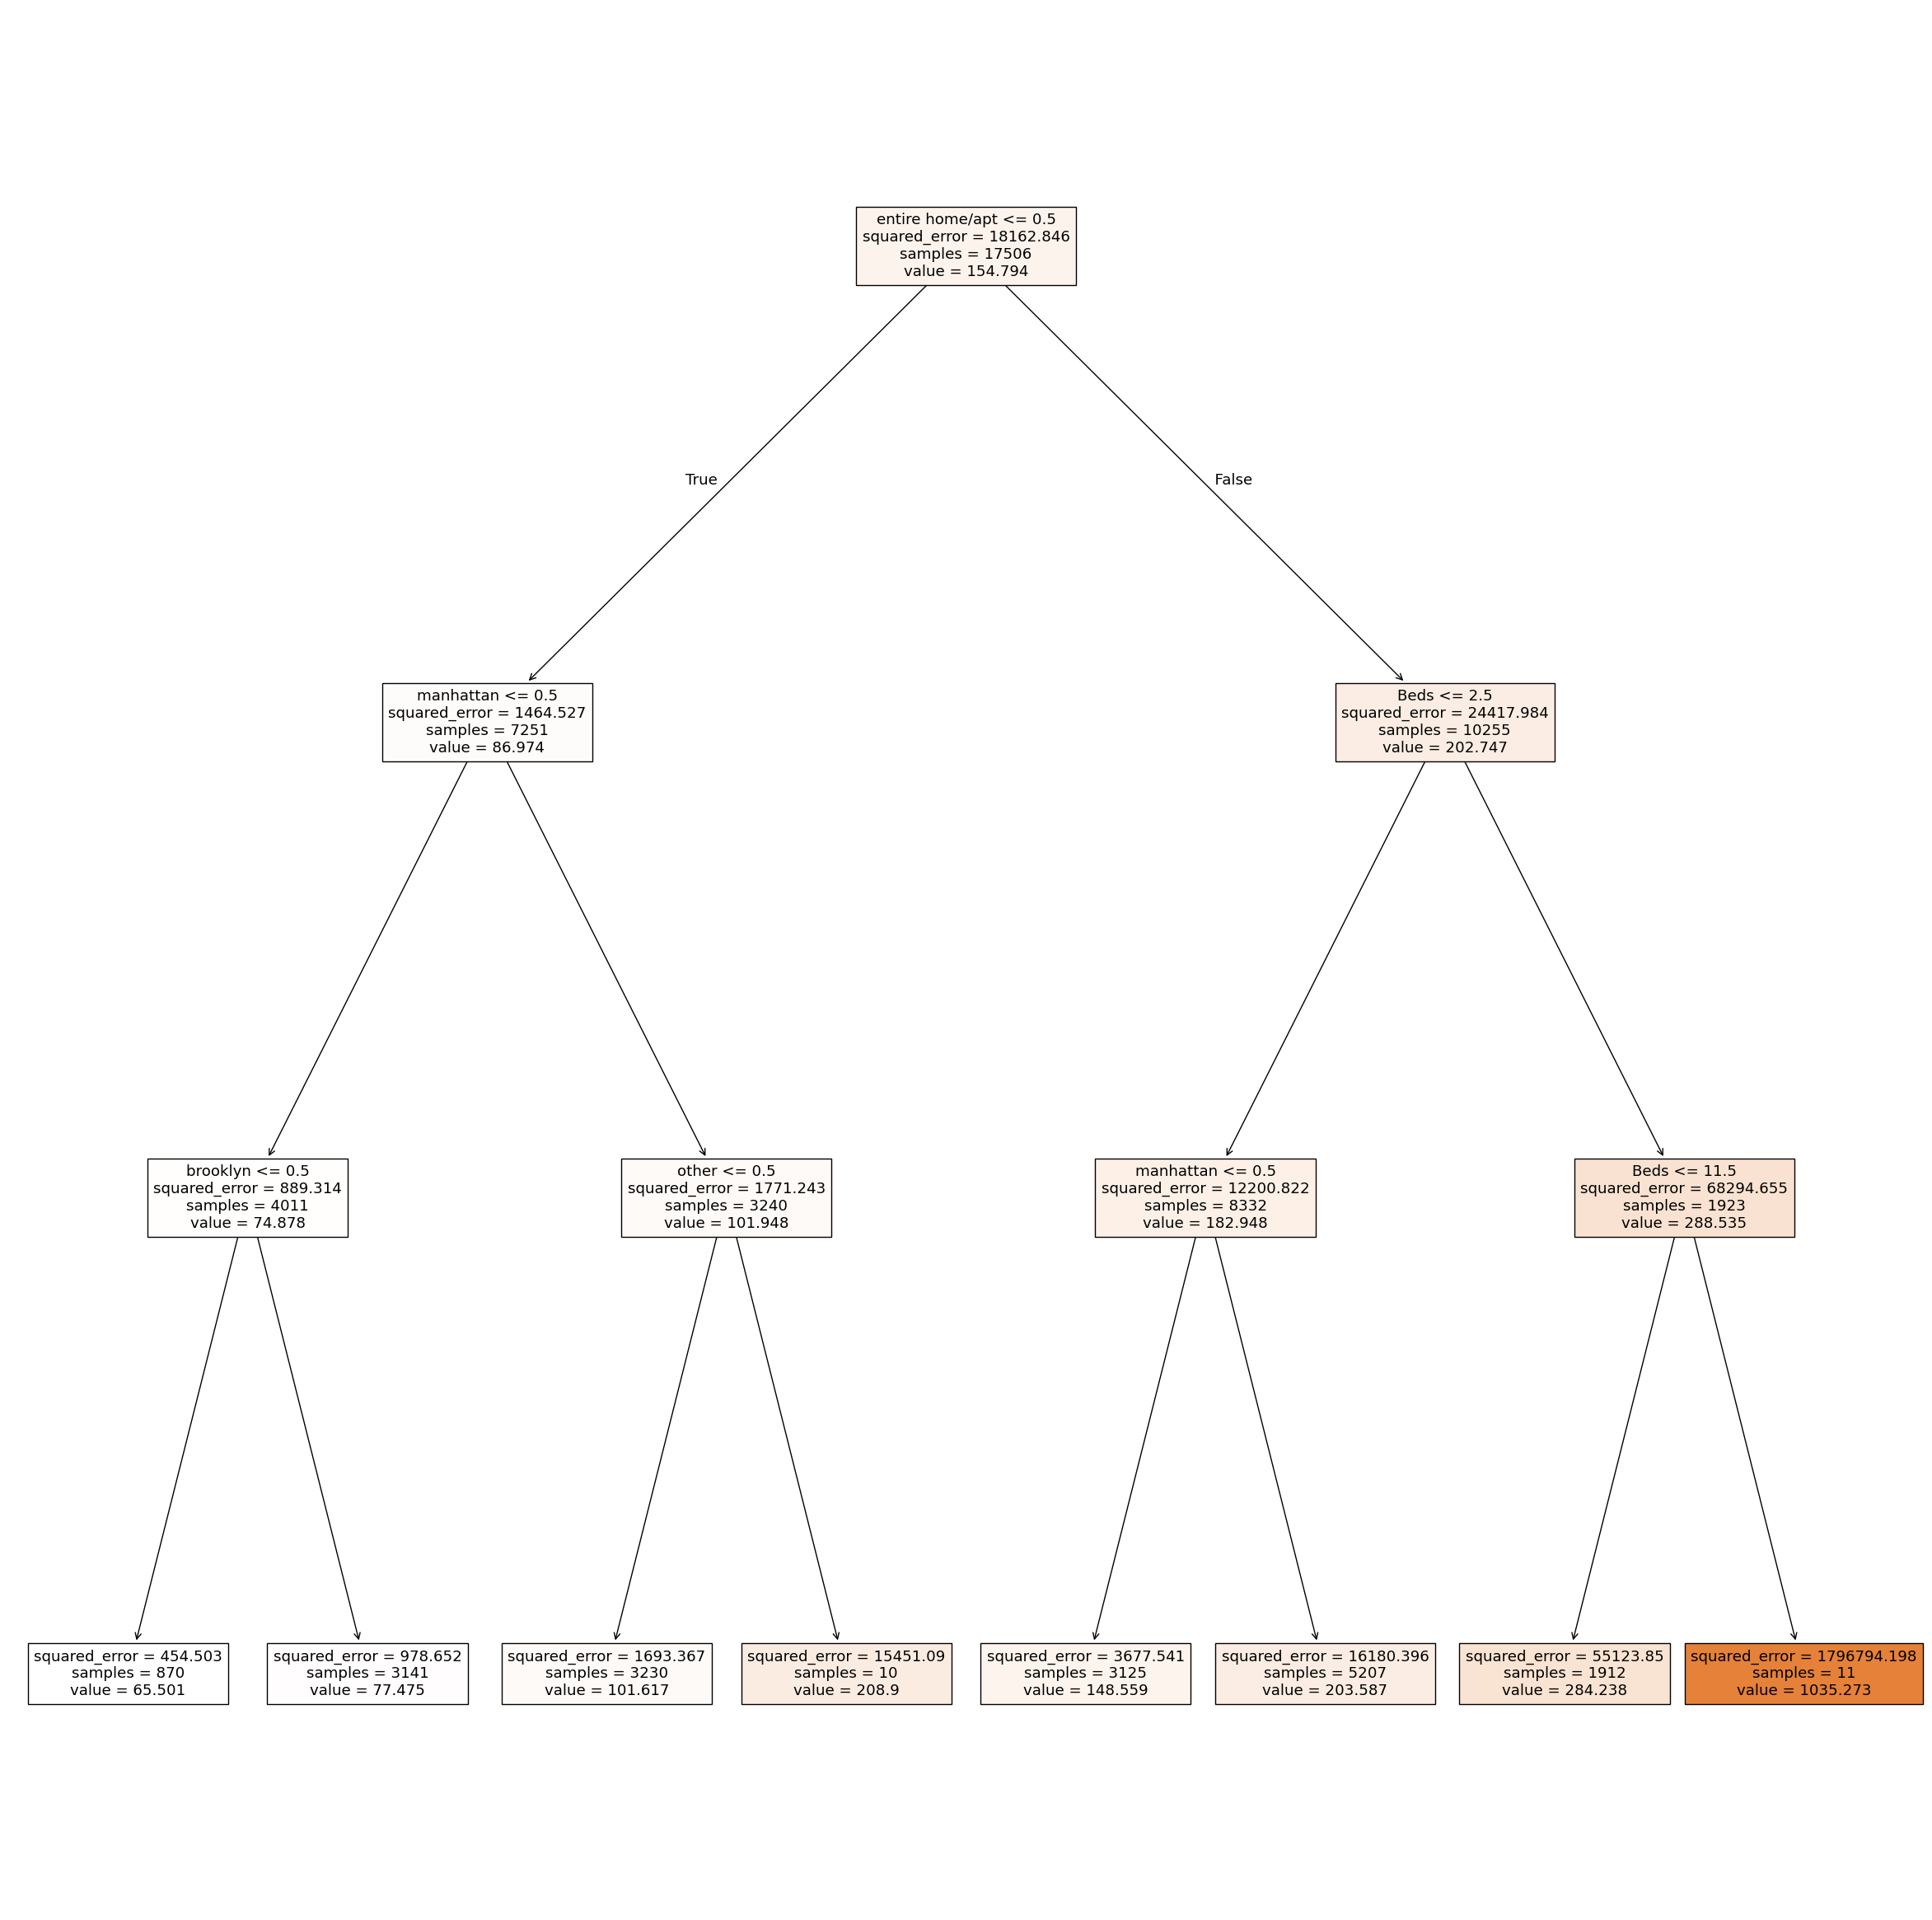

In [83]:
#random seed: 333

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# target variable
y = airbnb['price_clean']

# show unique categories for inspection
print('Property Type:', airbnb['Property Type'].unique())
print('Room Type:', airbnb['Room Type'].unique())
print('Neighbourhood:', airbnb['Neighbourhood'].unique())

# dummy variables:
type_dummy = pd.get_dummies(airbnb['Property Type'])
room_dummy = pd.get_dummies(airbnb['Room Type'])
nbhd_dummy = pd.get_dummies(airbnb['Neighbourhood'])

vars = ['Beds', 'Number of Records'] # same structure as in class
X = pd.concat([airbnb.loc[:, vars], type_dummy, nbhd_dummy, room_dummy], axis=1)

# Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

# Fit decision tree:
cart = DecisionTreeRegressor(max_depth=3)
cart = cart.fit(X_train, y_train)
y_hat_cart = cart.predict(X_test)  # Store regression tree predictions

# Fit linear regression:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)
y_hat_linreg = linreg.predict(X_test)  # Store linear regression predictions

# evaluate decision tree
mse_cart = mean_squared_error(y_test, y_hat_cart)
r2_cart = r2_score(y_test, y_hat_cart)
print(f"Decision Tree - MSE: {mse_cart:.2f}, R²: {r2_cart:.3f}")

# Evaluate Linear Regression
mse_linreg = mean_squared_error(y_test, y_hat_linreg)
r2_linreg = r2_score(y_test, y_hat_linreg)
print(f"Linear Regression - MSE: {mse_linreg:.2f}, R²: {r2_linreg:.3f}")

# Set aside predictions for further analysis
cart_preds = pd.Series(y_hat_cart, name='cart_predictions')
linreg_preds = pd.Series(y_hat_linreg, name='linear_regression_predictions')

# Combine predictions with test data (optional)
results = pd.DataFrame({
    'actual': y_test.reset_index(drop=True),
    'cart_pred': cart_preds,
    'linreg_pred': linreg_preds
})

print(results.head())

# Visualize decision tree
plt.figure(figsize=(30,30))
var_names = cart.feature_names_in_
plot_tree(cart, filled=True, feature_names=var_names)
plt.show()


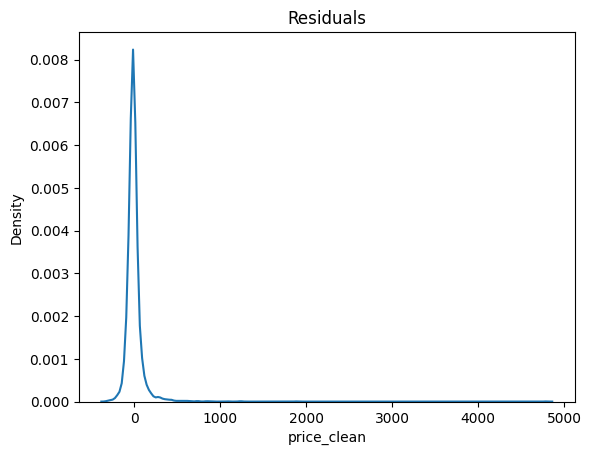

Rsq:  0.2598504346587245
RMSE:  119.27449776743569


In [75]:
# additional evaluation of the model

# residuals, rsq, RMSE
import seaborn as sns

e = y_test - y_hat_cart
sns.kdeplot(e).set(title='Residuals')
plt.show()

rsq = 1-np.sum(e**2)/np.sum( (y_test - np.mean(y_train))**2)
RMSE = np.sqrt(np.mean(e**2))

print('Rsq: ', rsq)
print('RMSE: ', RMSE)

**Question 3**


=== Seed 100 ===
Decision Tree - MSE: 14226.41, R²: 0.260
Linear Regression - MSE: 13457.86, R²: 0.300
   actual   cart_pred  linreg_pred
0     500  408.444134   349.347766
1      99   77.957751    57.766903
2      87   77.957751    57.766903
3      49  103.951129   150.293877
4      95  148.609282   176.861295


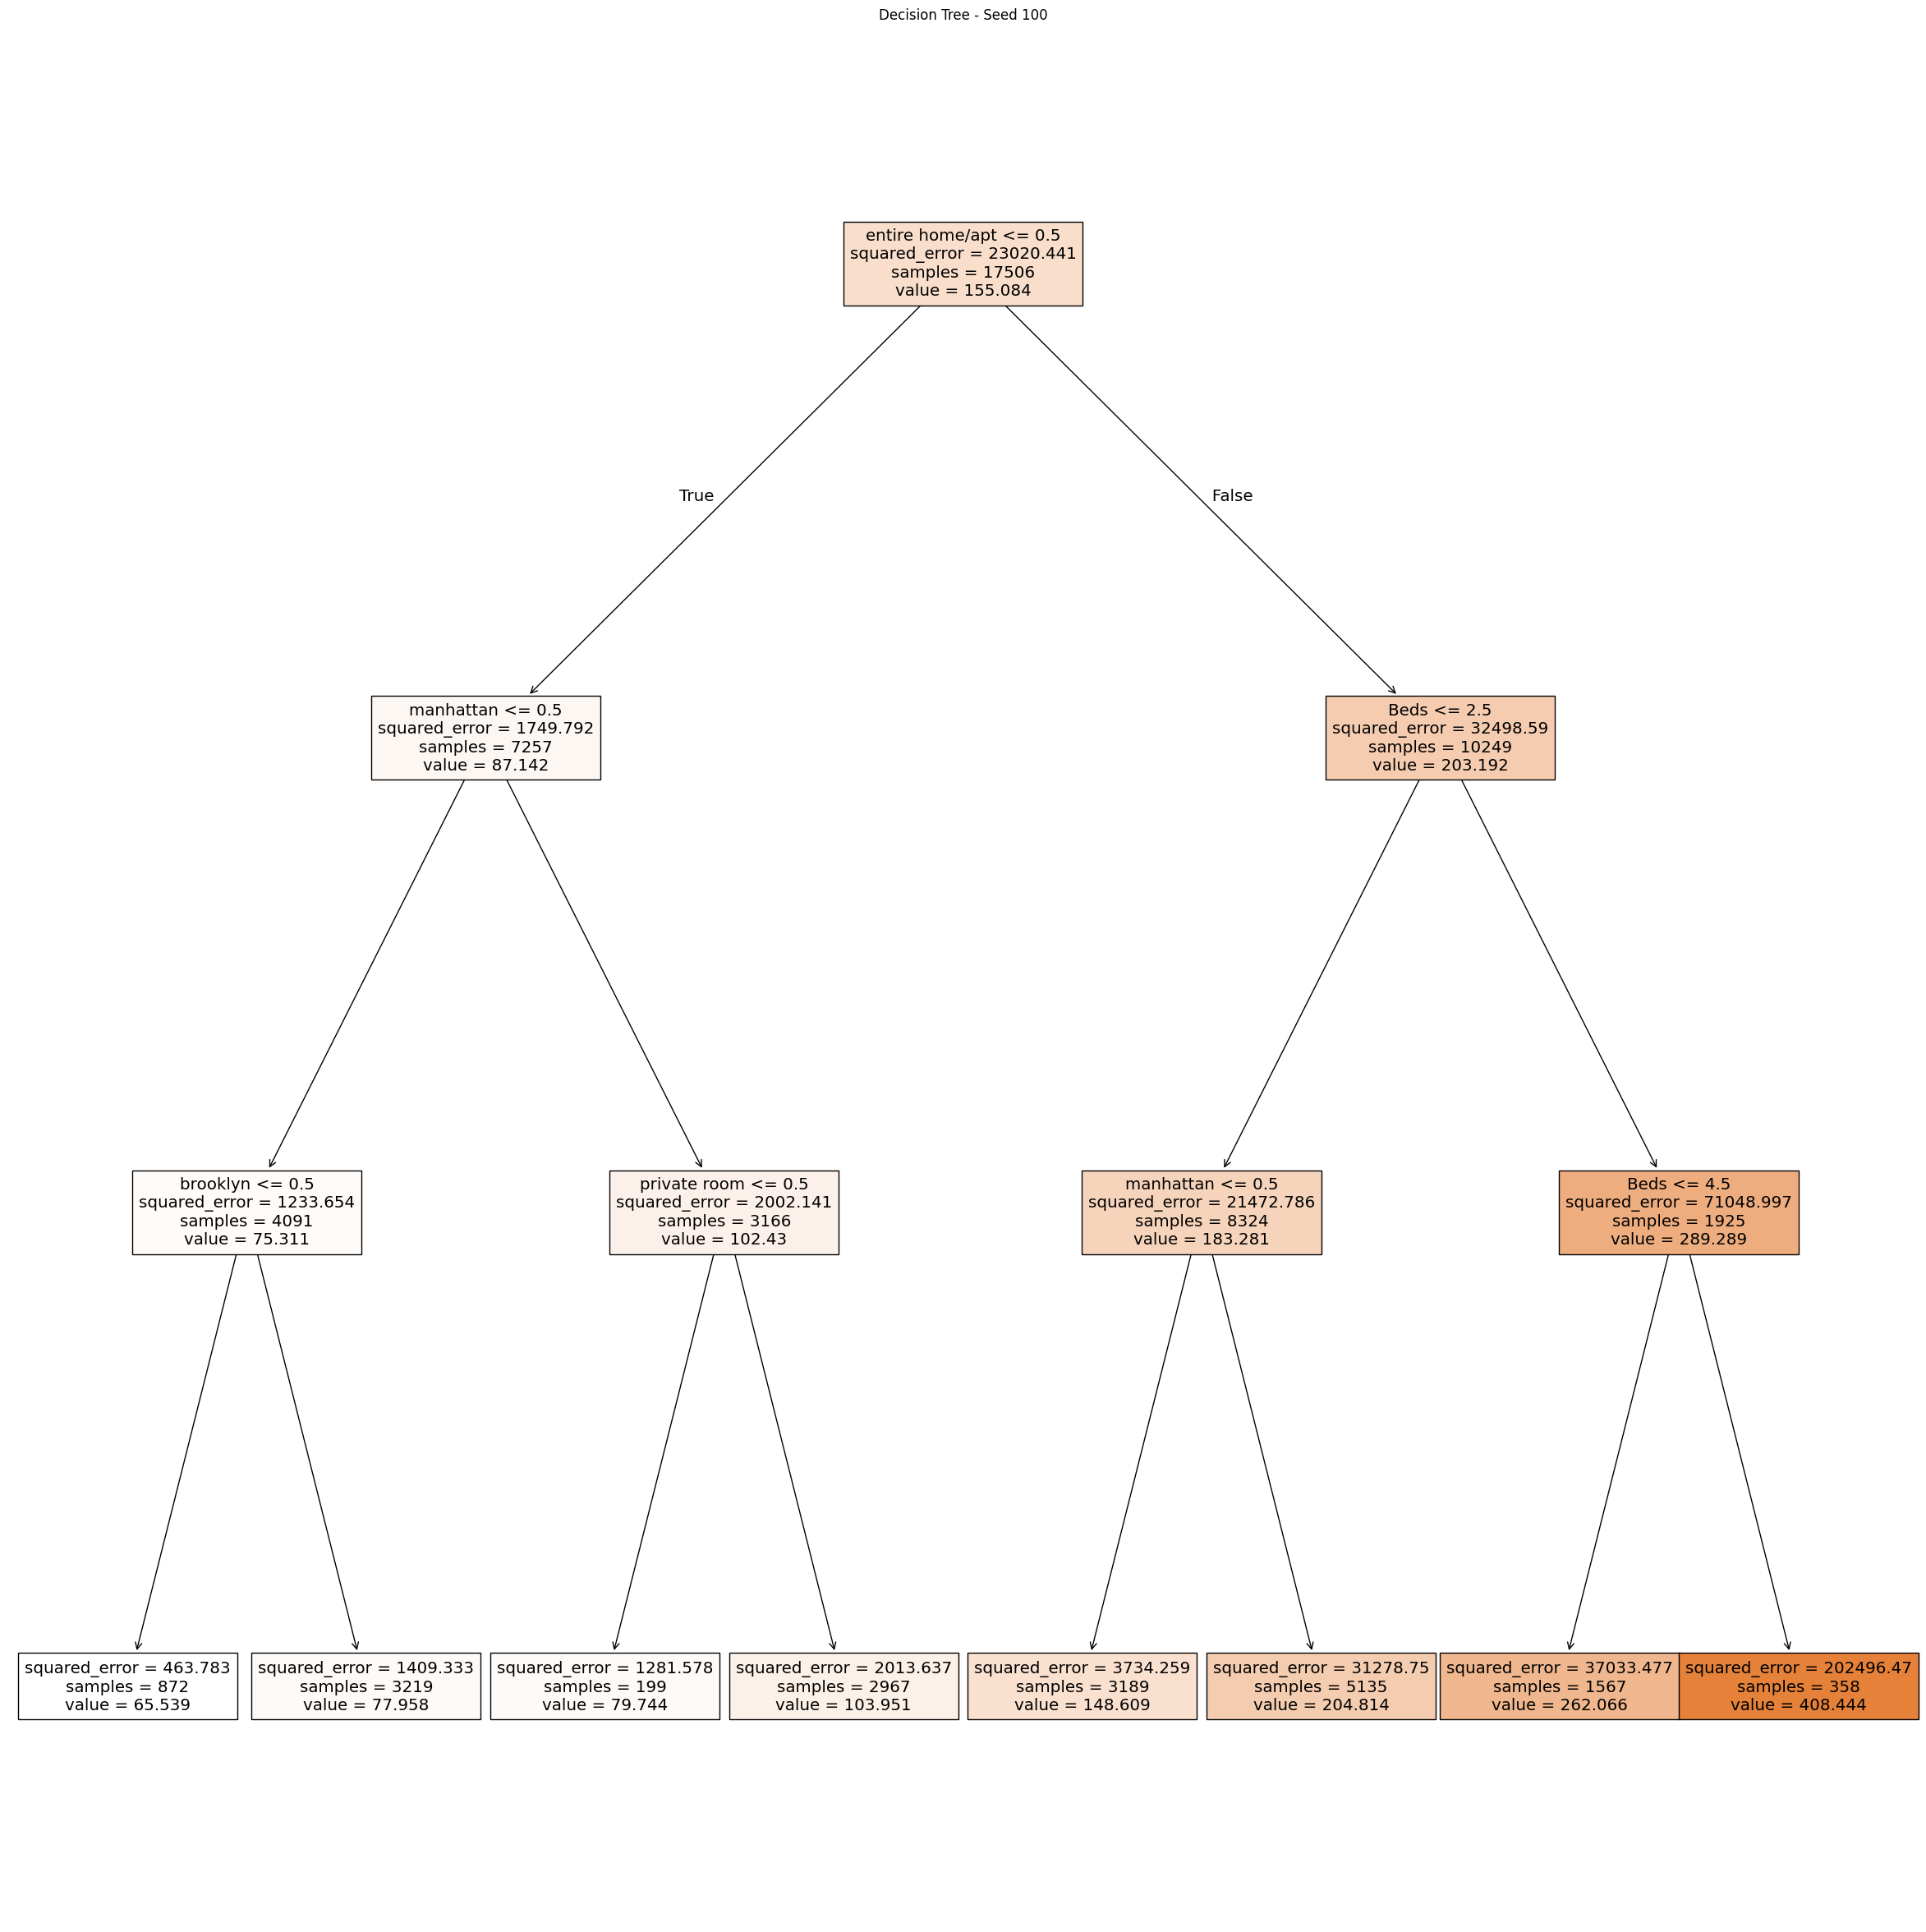


=== Seed 42 ===
Decision Tree - MSE: 7720.07, R²: 0.354
Linear Regression - MSE: 6874.18, R²: 0.425
   actual   cart_pred  linreg_pred
0     165  157.075655   136.897665
1     220  215.904055   189.677944
2     145  103.639684   110.174019
3     145  215.904055   231.564399
4     285  215.904055   231.564399


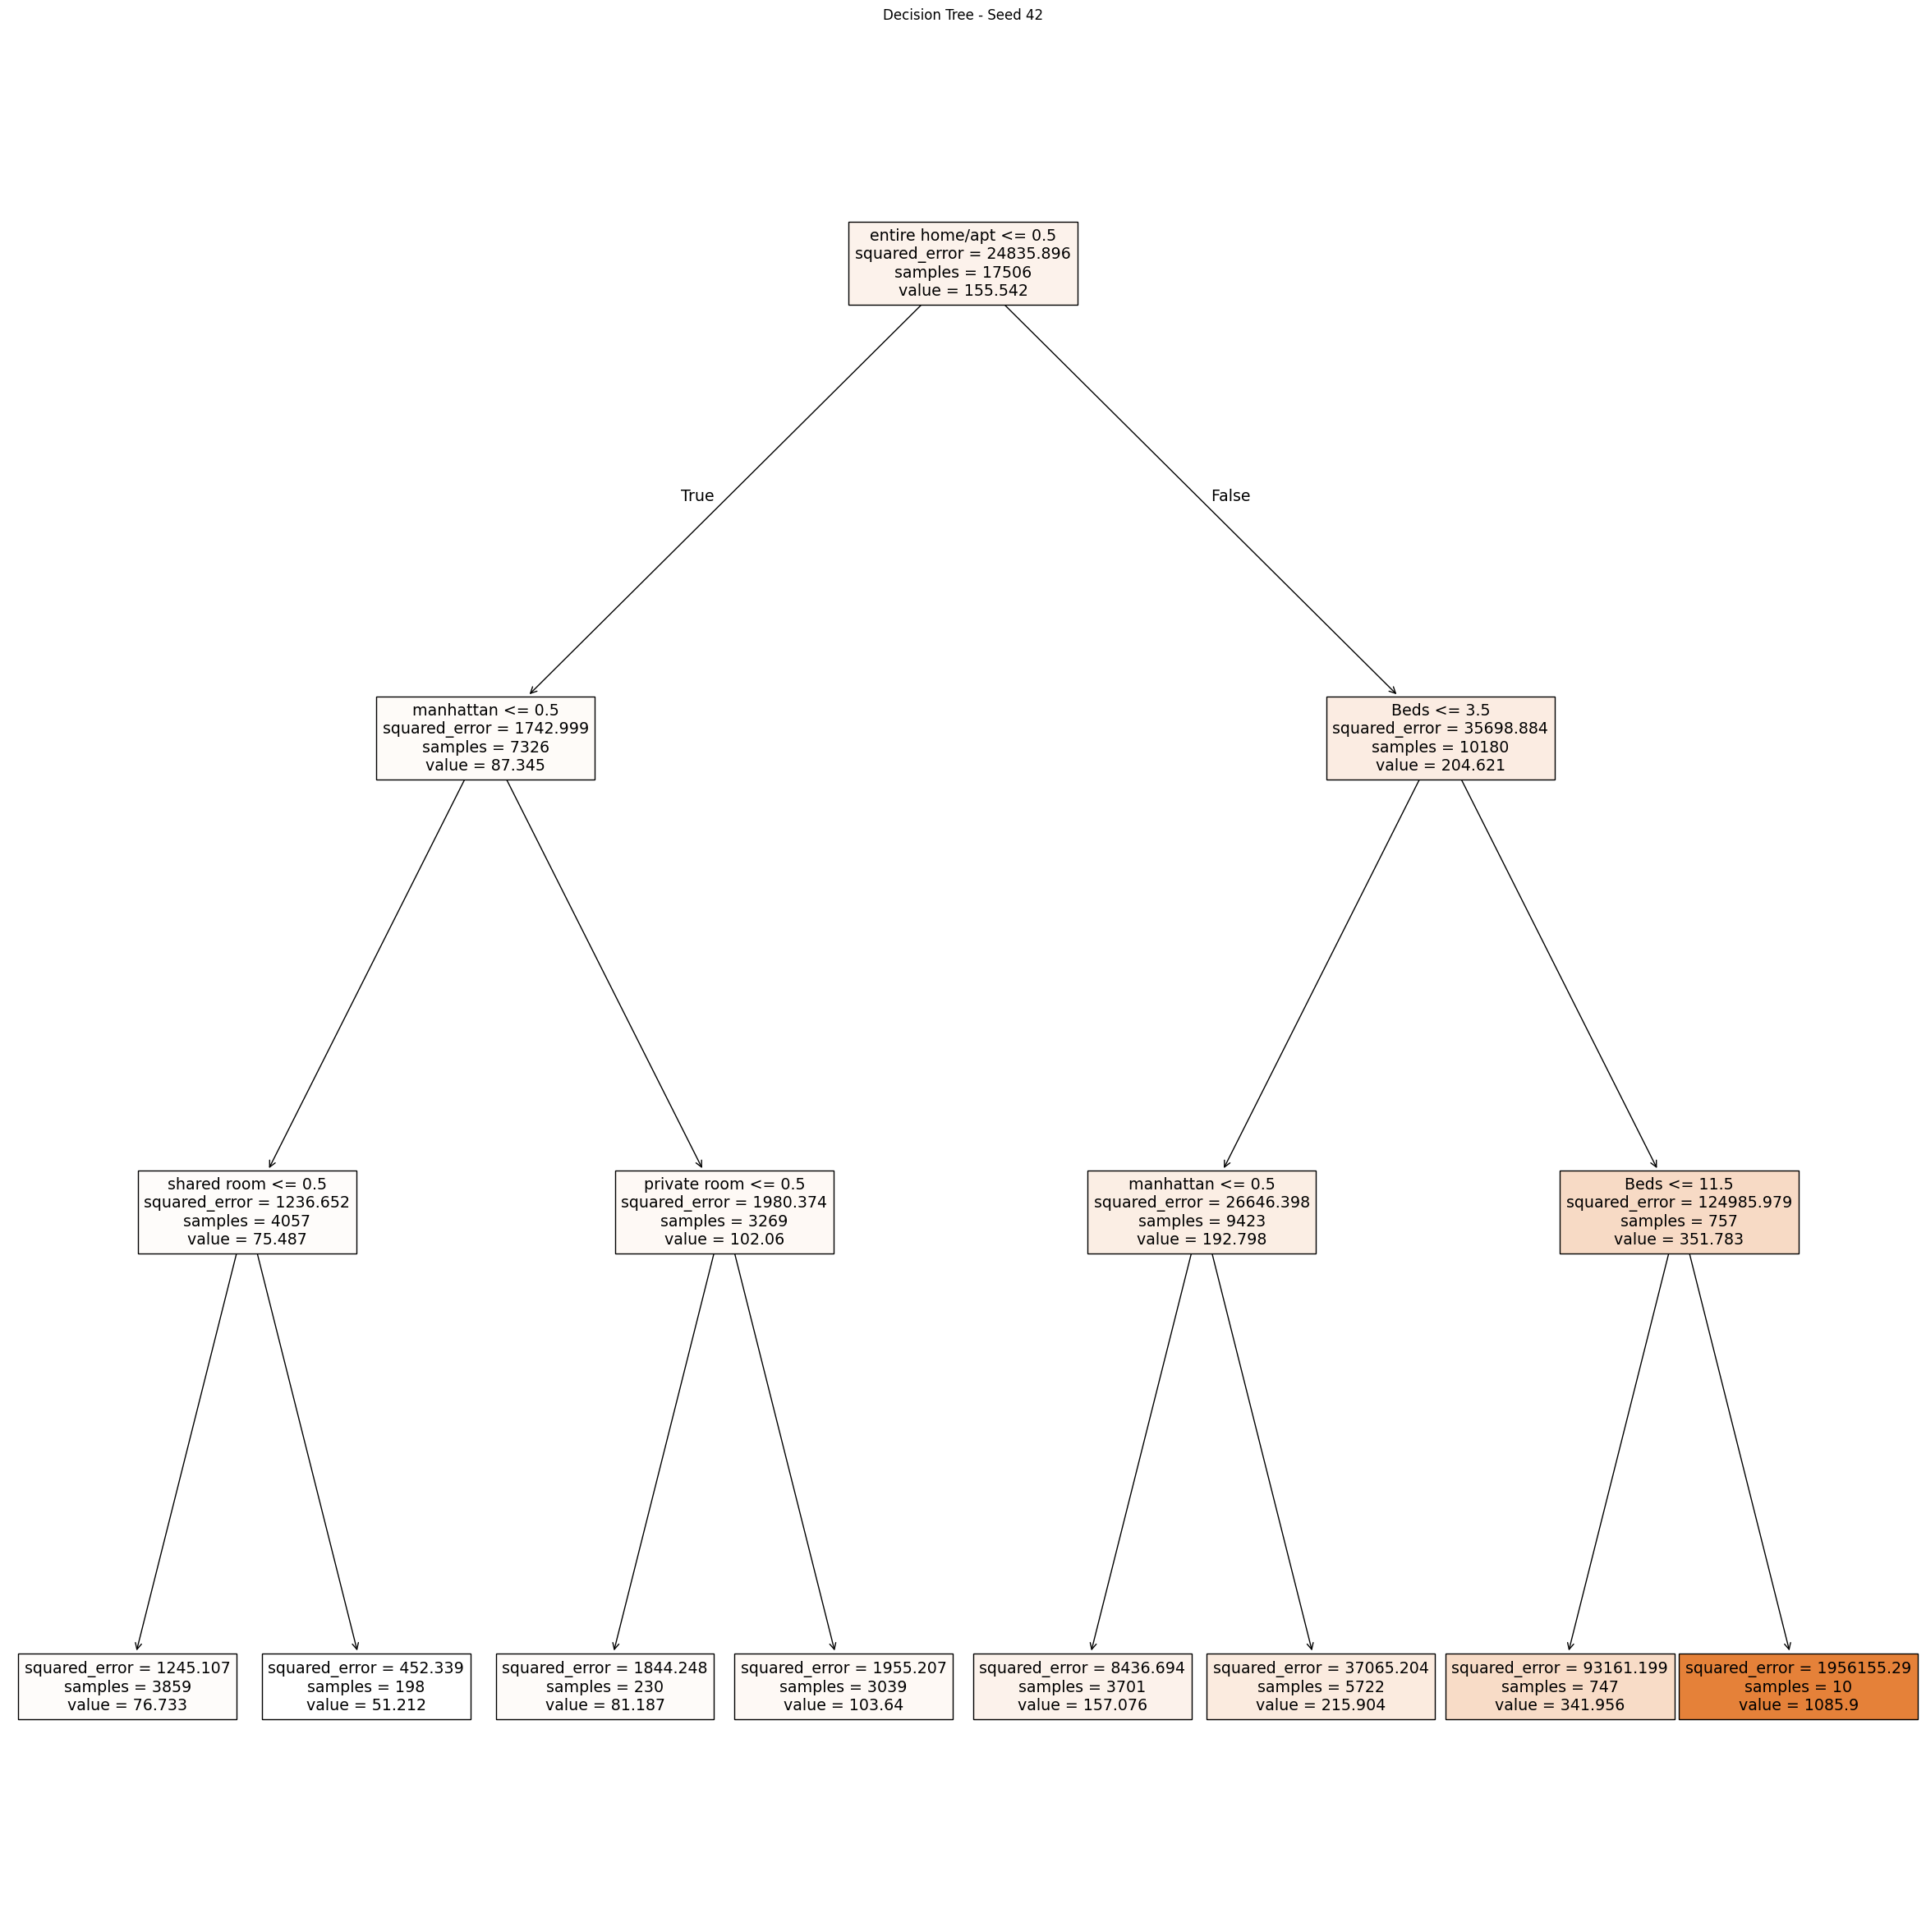


=== Seed 2025 ===
Decision Tree - MSE: 28911.22, R²: 0.119
Linear Regression - MSE: 28043.70, R²: 0.146
   actual   cart_pred  linreg_pred
0     198  214.189649   230.926393
1     115   76.081229   119.929912
2      55   76.081229    56.923798
3     100  156.478589   177.695082
4     160  156.478589   240.701196


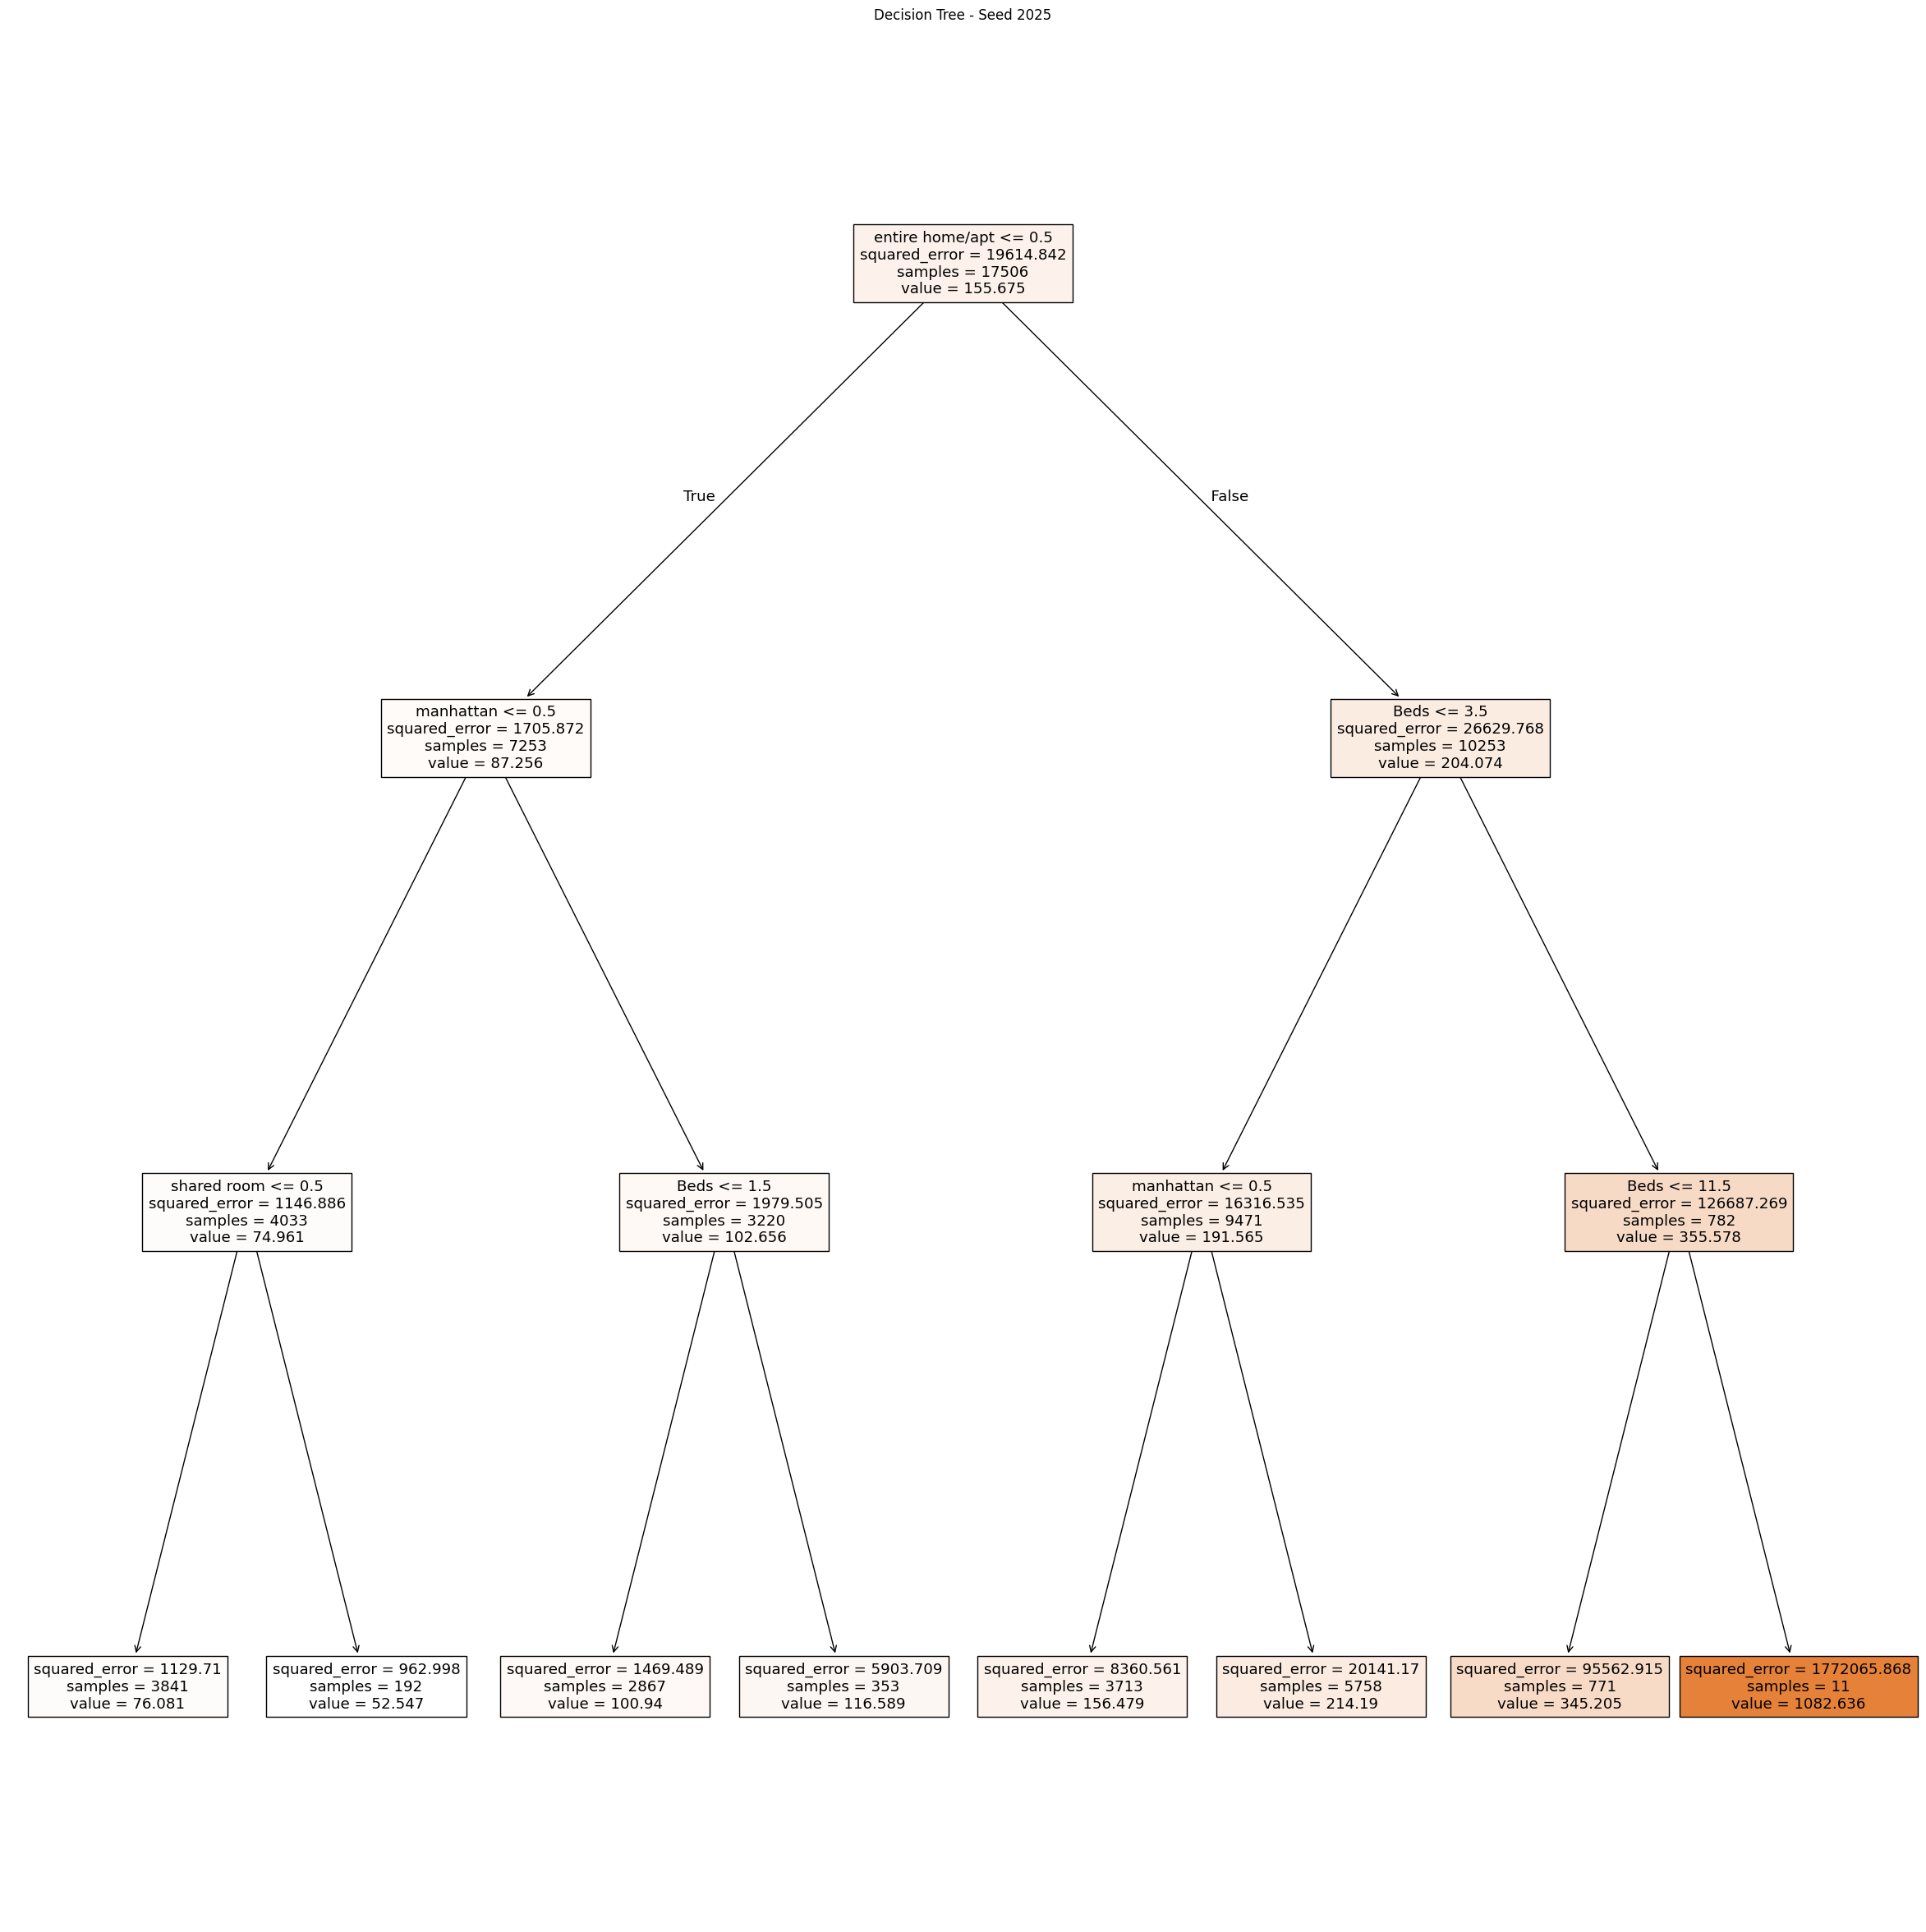

In [82]:
seeds = [100, 42, 2025]

# Optionally, store results for all seeds
results_dict = {}

for seed in seeds:
    print(f"\n=== Seed {seed} ===")
    # Always start from airbnb_cleaned
    y = airbnb_cleaned['price_clean']
    type_dummy = pd.get_dummies(airbnb_cleaned['Property Type'])
    room_dummy = pd.get_dummies(airbnb_cleaned['Room Type'])
    nbhd_dummy = pd.get_dummies(airbnb_cleaned['Neighbourhood'])
    vars = ['Beds', 'Number of Records']
    X = pd.concat([airbnb_cleaned.loc[:, vars], type_dummy, nbhd_dummy, room_dummy], axis=1)

    # Train-test split (this will be new for each seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Fit decision tree
    cart = DecisionTreeRegressor(max_depth=3)
    cart.fit(X_train, y_train)
    y_hat_cart = cart.predict(X_test)

    # Fit linear regression
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_linreg = linreg.predict(X_test)

    # Evaluate Decision Tree
    mse_cart = mean_squared_error(y_test, y_hat_cart)
    r2_cart = r2_score(y_test, y_hat_cart)
    print(f"Decision Tree - MSE: {mse_cart:.2f}, R²: {r2_cart:.3f}")

    # Evaluate Linear Regression
    mse_linreg = mean_squared_error(y_test, y_hat_linreg)
    r2_linreg = r2_score(y_test, y_hat_linreg)
    print(f"Linear Regression - MSE: {mse_linreg:.2f}, R²: {r2_linreg:.3f}")

    cart_preds = pd.Series(y_hat_cart, name='cart_predictions')
    linreg_preds = pd.Series(y_hat_linreg, name='linear_regression_predictions')

    # Store predictions/results for this seed
    results = pd.DataFrame({
        'actual': y_test.reset_index(drop=True),
        'cart_pred': cart_preds,
        'linreg_pred': linreg_preds
    })
    print(results.head())

    # Store results dictionary if needed for further analysis
    results_dict[seed] = {'decision_tree': cart, 'linear_model': linreg, 'preds': results}

    # Visualize decision tree
    plt.figure(figsize=(30,30))
    var_names = cart.feature_names_in_
    plot_tree(cart, filled=True, feature_names=var_names)
    plt.title(f'Decision Tree - Seed {seed}')
    plt.show()

Need to respond to written part of Q3